# Tarea 3: Especificaciones de la producción 

En esta subtarea se pide detallar especificaciones sobre la plataforma de producción para poder operar estos modelos a medio plazo. 

## Tabla de Contenidos <a class="anchor" id="0"></a>

1. [Data Warehouse](#1) <br>
    1.1 [Especificaciones del data warehouse](#11) <br>
2. [Hosting del dashboard](#2) <br>
3. [Modelos de Machine Learning ](#3) <br>

Los modelos o productos a productivizar son los siguientes:

- **Dashboard.** Este producto permitirá a los empleados de la empresa visualizar el estado de la performance actual e histórica de easyMoney pudiendo obtener una imagen global y detallada del número de altas, bajas, ingresos, análisis de los clientes... Este producto contiene tanto la parte de análisis donde puede visualizarse la información de productos, clientes, cashflow, etc. como la parte de segmentación en la Tarea 2 y 4, donde se puede visualizar la información de cada cluster.
- **Recomendación.** Este modelo permite obtener las recomendaciones de productos para cada cliente o tipo de clientes. Estas recomendaciones después son pasadas al Modelo de Compra para determinar su probabilidad de éxito. 
- **Modelo de Compra.** El Modelo de Compra consiste en un clasficador binario que permite obtener la probabilidad de compra dadas el estado y características del cliente. 
- **Personalización.**  Este modelo se trata de un modelo de segmentación que permite determinar las creatividades de los clientes a los que se espera enviar un email con el objetivo de que acaben comprando un producto.

Resulta complicado estimar el precio total de la producción pues los precios de los servicios varían en función de su utilización. Se ha apostado por Amazon como nuestro proveedor en Cloud, en los siguientes puntos se determinan los precios generales como los precios según su uso. Habría que profundizar en cada una de los puntos e incluso no se descarta contactar con Amazon para determinar cuáles son nuestras necesidades y qué producto se ajusta mejor a éstas; pudiendo finalmente dar un precio estimado correcto.

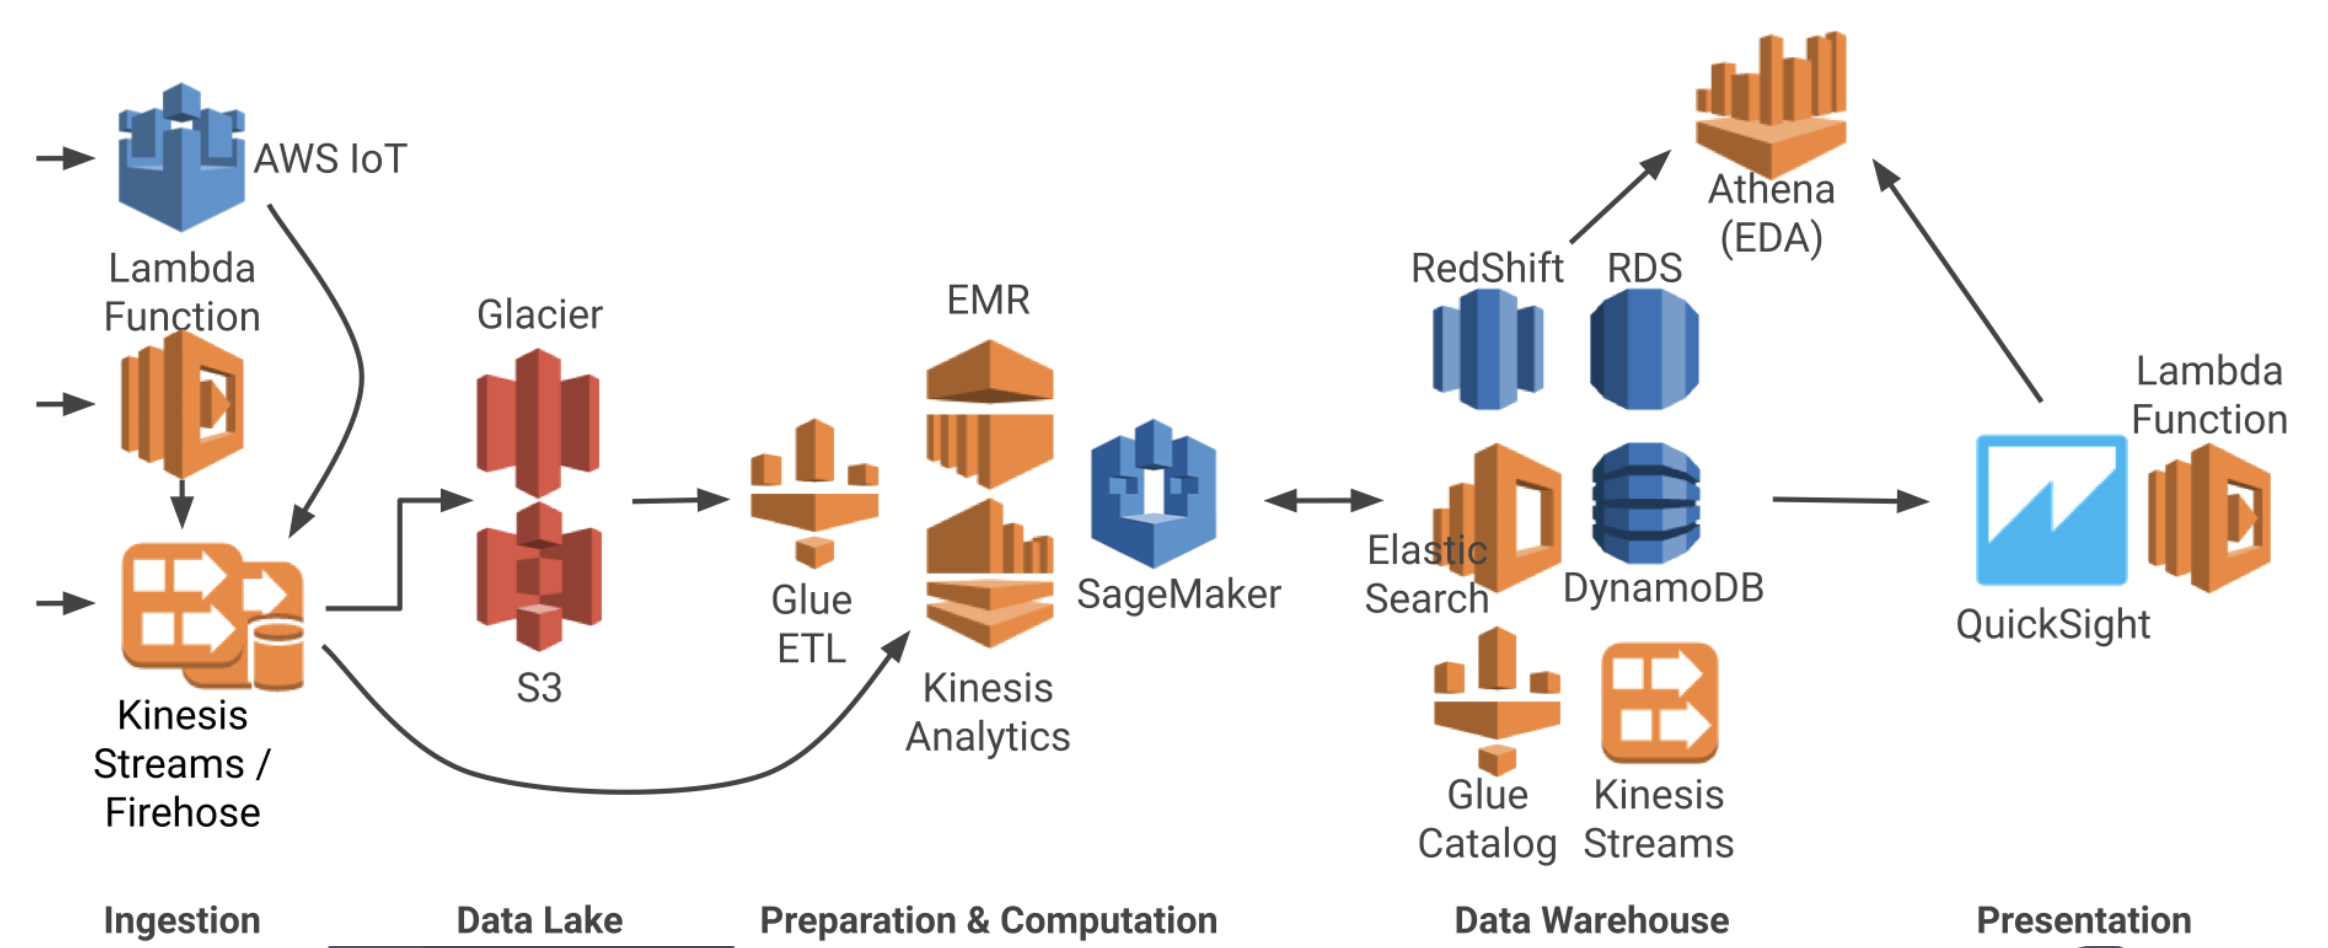

In [1]:
from IPython.display import Image
Image('../input/easymoneygrupo5/amazon.png', height = 150)

## Data Warehouse <a class="anchor" id="1"></a>

[Tabla de Contenidos](#0) 

El Data Warehouse es el lugar donde se almacenan las tablas con los datos con la información demográfica de los clientes, su actividad comercial y los productos que han contratado. Además de tablas intermedias con datos ya preprocesados para la ingesta de datos para el dashboard, de esta manera la velocidad de carga en el dashboard se ve reducida increíblemente. 

Al empezar el proyecto se nos brindaron los 3 archivos siguientes:

- sociodemographic_df.csv (301 MB)
- commercial_activity_df.csv (383 MB)
- products_df.csv (365 MB)

Sin embargo a lo largo de proyecto se han generado tablas intermedias para la visualización del dashboard y resultados del resto de tareas (altas, bajas, número de clientes activos, altas pendientes de cobro...), tablas de fuentes exteriores (provincias o la información de países) y resultados obtenidos de los modelos desarrollados. 

Para poder dimensionalizar el data warehouse se estudia cuál es la cantidad de datos por mes (es decir su velocidad). La estructura de tablas nos parece adecuada, aunque en algunas de ellas se propone aumentar la velocidad de ingesta de datos con el fin de poder obtener la información del estado de los clientes antes para poder reaccionar lo más rápido posible ante cualquier tipo de obstáculo o problema y recoger feedback del plan de marketing cuanto antes; y no pasado un mes, cuando probablemente sea tarde para cualquier tipo de acción.

Actualmente, la cantidad de datos recibidos de manera mensual es la siguiente:
- sociodemographic_df.csv (13.347 MB/mes)
- commercial_activity_df.csv (34.322 MB/mes)
- products_df.csv (17.161 MB/mes)

In [2]:
import pandas as pd 
import numpy as np 

In [3]:
DIR_PATH = '/Users/carlosperezricardo/Documents/data/'
DIR_PATH = '../input/easymoneygrupo5/'

commercial_activity = pd.read_csv(DIR_PATH+'commercial_activity_df.csv', encoding='utf-8')
commercial_activity.drop(columns=['Unnamed: 0'], inplace=True)

products = pd.read_csv(DIR_PATH+'products_df.csv', encoding='utf-8')
products.drop(columns=['Unnamed: 0'], inplace=True)

sociodemographic = pd.read_csv(DIR_PATH+'sociodemographic_df.csv', encoding='utf-8')
sociodemographic.drop(columns=['Unnamed: 0'], inplace=True)

LAST_DATE = "2018-05-28"

In [4]:
commercial_activity = commercial_activity[commercial_activity['pk_partition']==LAST_DATE]
products = products[products['pk_partition']==LAST_DATE]
sociodemographic = sociodemographic[sociodemographic['pk_partition']==LAST_DATE]

print('El commercial_activity_df ocupa {:1f} MB'.format(commercial_activity.memory_usage(index=True).sum()/1048576))
print('El products_df ocupa {:1f} MB'.format(products.memory_usage(index=True).sum()/1048576))
print('El sociodemographic_df ocupa {:1f} MB'.format(sociodemographic.memory_usage(index=True).sum()/1048576))

El commercial_activity_df ocupa 13.347488 MB
El products_df ocupa 34.322113 MB
El sociodemographic_df ocupa 17.161057 MB


Se propone aumentar la velocidad de la ingesta de datos de la tabla products_df pasando de mensual a semanal. Por lo que la cantidad de datos mensuales se multiplicará por 4. De manera que products_df pasará de 34.3 MB a 137.3 MB. 

Para la tabla products_df sería una buena idea cambiar el método de almacenamiento actual, en lugar de guardar el status de todos los productos para cada cliente, se propone guardar únicamente los cambios de status (ya sea debido a altas o bajas), de esta manera no se almacena información innecesaria de clientes que no tienen actividad alguna; y el tamaño del dataset se verá reducido (y más si pensamos a largo plazo). Aunque el sistema actual es fácil de interpretar y de trabajar con él. 

### Especificaciones del data warehouse <a class="anchor" id="11"></a>

[Tabla de Contenidos](#0) 

Para el Data Warehouse se opta por PostgreSQL utilizando el almacenamiento en cloud de Amazon con <a href="https://aws.amazon.com/es/rds/postgresql/pricing/">Amazon RDS</a>, similarmente al utilizado en el dashboard en la Tarea 1. El precio aproximado sería de unos 10 euros (10,439 USD) al mes contratando el db.t3.micro que es una instancia. También existen servicios on-premise, sin embargo el plan básico está perfectamente dimensionado para los requerimientos actuales. Si en el futuro aumenta la ingesta y el paquete actual no satisface la demanda y se puede aumentar las dimensiones pagando más.

Además sería interesante contratar un servicio de <a href="https://aws.amazon.com/s3/pricing/?trkCampaign=acq_paid_search_brand&sc_channel=PS&sc_campaign=acquisition_IBERIA&sc_publisher=Google&sc_category=Storage&sc_country=IBERIA&sc_geo=EMEA&sc_outcome=acq&sc_detail=s3%20cloud%20storage%20pricing&sc_content={ad%20group}&sc_matchtype=e&sc_segment=495089203403&sc_medium=ACQ-P|PS-GO|Brand|Desktop|SU|Storage|S3|IBERIA|EN|Sitelink&s_kwcid=AL!4422!3!495089203403!e!!g!!s3%20cloud%20storage%20pricing&ef_id=Cj0KCQjw78yFBhCZARIsAOxgSx16rja8WMTrcBsH3IintCiWOFg3JgtIr8wEhPMRPHCMvF4KxwY6EfwaAmB1EALw_wcB:G:s&s_kwcid=AL!4422!3!495089203403!e!!g!!s3%20cloud%20storage%20pricing">Amazon S3</a>, para el almacenamiento de datos que no sean estrictamente en SQL como ficheros csv, txt, pickles, modelos de Machine Learning o imágenes; archivos que a menudo necesitan los modelos. Para un S3 Standard el precio para los primeros 50 TB / Month 0.0245 USD por GB. 

## Hosting del dashboard <a class="anchor" id="2"></a>

[Tabla de Contenidos](#0) 

Para el hosting del dashboard y las visualizaciones de las segmentaciones se ha utilizado PythonAnywhere donde se pagan 6.05 USD (5 euros) en su versión más básica que presenta algunas limitaciones en cuanto a utilización de la CPU y memoria. Sin embargo, sería interesante pasar a otro lenguaje web como Javascript donde se puede mejorar la calidad de la webs y permite realizar acciones y web más complicadas (Dash presenta sus limitaciones). 

Para el hosting se optaría por otro producto de Amazon para así tener todo con la misma compañía (si se desea ver en web) o utilizar alguna herramienta de Business Intelligence como PowerBI o Tableau. 

Los precios son los siguientes: 
- PowerBI. Tiene versión y únicamente se cobra 10 USD al editor (sólo para Windows).
- Tableau. Tableau ofrece una versión Viewer con un precio de 12 USD y otra Explorer de 35 USD.
- Amazon. Sería un producto realizado de manera interna, se necesitan conocimientos de Web Development (JavaScript, CSS, React, Backend, conociemiento para conexión con base de datos...). 

Si finalmente se opta por el dashboard en formato web sería necesario reducir la latencia de la página web, es decir el tiempo que tarda en leer los datos, procesarlos y cargarlos. Por ejemplo para el caso del dashboard (Tarea 1) es rápido dado que todas las tablas son preprocesadas y preparadas y algunas imágenes son mostradas en estático pero para el caso de las visualizaciones de las segmentaciones el tiempo de carga es excesivo al tener que leer los datos y hacer los subsets por clusters y mostrar las imágenes. 

## Modelos de Machine Learning <a class="anchor" id="3"></a>

[Tabla de Contenidos](#0) 

Los modelos desarrollados y la frecuencia de cada uso que se espera de cada uno de estos serán los siguientes:

- Modelo de clusterización de la cartera actual de clientes. (semestral o incluso anual) - Tarea 2
- Modelo de recomendación: Motor de recomendación y Modelo de Compra. (mensual) - Tarea 3
- Modelo de segmentación de emails. (mensual) - Tarea 4

Para el caso del Modelo de segmentación de emails, al ser ser un dataset con pocos datos este modelo podría ser realizado en local obteniendo los datos de las bases de datos. Mientras que los otros modelos necesitan mucha capacidad de pre processing y preparación de los datos por lo que sería interesante utilizar el servicio <a href="https://aws.amazon.com/es/rds/postgresql/pricing/">AWS Lambda</a> (Ejecute código sin tener que pensar en los servidores o los clústeres. Pague solo por lo que utiliza). 

El precio de AWS Lambda depende de su uso sus precios para Solicitudes es de 0,20 USD por un millón de solicitudes y el precio de Duración es de 0,0000166667 USD por cada GB/segundo. El precio de la duración depende del volumen de memoria asignado a la función. Puede asignar a la función cualquier volumen de memoria desde los 128 MB a los 10, 240 MB en incrementos de 1 MB. Por ejemplo para 128 Memoria (MB) el Precio por 1 ms es de 0,0000000021 USD.

Además también se propone desarrollar los siguientes modelos. 

- Modelo de Churn. Identificar qué clientes son más proclives a abandonar la compañía antes de que se marchen.

Los Modelos de Machine Learning pueden ser entrenados e implementados en <a href="https://aws.amazon.com/es/getting-started/hands-on/build-train-deploy-machine-learning-model-sagemaker/">Amazon SageMaker</a> o utilizando el servicio AWS Lambda dado que los modelos tampoco son muy complicados. Empresas como <a href="https://www.h2o.ai/">H20.ai</a> ofrecen servicios para la optimización de hiperparámetros, utilizarlos para la obtención de los mejores parámetros para el modelo de Compra sería interesante. 